In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, ConfusionMatrixDisplay

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/hotel-classification-dataset.csv')
df.shape

(290315, 17)

In [4]:
df.drop(columns=['Review_Date', 'lat', 'lng'], inplace=True)

In [5]:
df['Tags'] = df['Tags'].astype(str)

In [6]:
df['Tags'] = df['Tags'].apply(lambda x: eval(x.strip()))

# Tách các giá trị thành các cột riêng
tags_df = pd.DataFrame(df['Tags'].tolist())

# Đổi tên cột
tags_df.columns = [f"Tags_{i+1}" for i in range(tags_df.shape[1])]

# Kết hợp vào DataFrame ban đầu
df = pd.concat([df, tags_df], axis=1)

# Bỏ cột 'tag' gốc nếu không cần thiết
df = df.drop('Tags', axis=1)

In [ ]:
def normalize_value(value):
    value = str(value).strip().lower()
    if value in ['nothing', 'no negative', ' nothing', ' no negative', 'no positive', ' no postive']:
        return 'nothing'
    return value
df['Negative_Review'] = df['Negative_Review'].apply(normalize_value)
df['Positive_Review'] = df['Positive_Review'].apply(normalize_value)
df.head(10)

In [7]:
# Bước 2: Chuyển "nothing" thành 0, tất cả các giá trị khác thành 1
df['Negative_Review'] = df['Negative_Review'].apply(lambda x: 0 if x == "nothing" else 1)

In [8]:
# Bước 2: Chuyển "nothing" thành 0, tất cả các giá trị khác thành 1
df['Positive_Review'] = df['Positive_Review'].apply(lambda x: 0 if x == "nothing" else 1)

In [9]:
mapping = {
    "Low_Reviewer_Score": 0,
    "Intermediate_Reviewer_Score": 0,
    "High_Reviewer_Score": 1
}

df['Reviewer_Score'] = df['Reviewer_Score'].map(mapping)

In [10]:
cate_cols = df.select_dtypes(include=['object']).columns
cate_cols

Index(['Hotel_Address', 'Hotel_Name', 'Reviewer_Nationality', 'Tags_1',
       'Tags_2', 'Tags_3', 'Tags_4', 'Tags_5', 'Tags_6'],
      dtype='object')

In [11]:
le = LabelEncoder()
for cols in cate_cols:
  df[cols] = le.fit_transform(df[cols])

<Axes: xlabel='Reviewer_Score', ylabel='Count'>

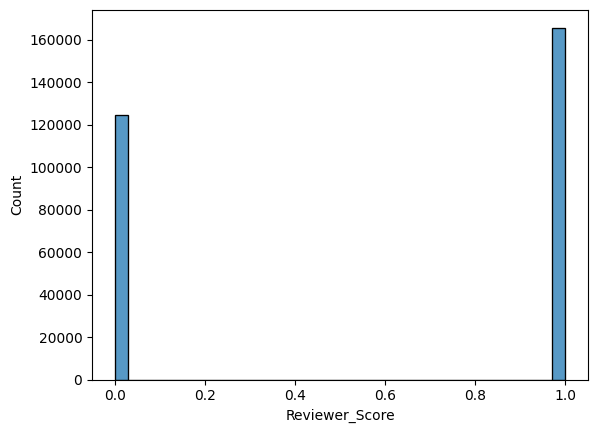

In [12]:
sns.histplot(x=df['Reviewer_Score'])

In [ ]:
plt.figure(figsize=(12, 8))

# Vẽ boxplot cho tất cả các cột số
sns.boxplot(data=df)

# Hiển thị
plt.xticks(rotation=90)
plt.title("Boxplot cho tất cả các cột số")
plt.show()

In [13]:
for cols in df.columns:
  iqr = df[cols].quantile(0.75) - df[cols].quantile(0.25)
  upper_bound = df[cols].quantile(0.75) + 1.5 * iqr
  lower_bound = df[cols].quantile(0.25) - 1.5 * iqr
  df = df[(df[cols] >= lower_bound) & (df[cols] <= upper_bound)]

In [ ]:
plt.figure(figsize=(12, 8))

# Vẽ boxplot cho tất cả các cột số
sns.boxplot(data=df)

# Hiển thị
plt.xticks(rotation=90)
plt.title("Boxplot cho tất cả các cột số")
plt.show()

In [14]:
X = df.drop(columns=['Reviewer_Score'])
y = df['Reviewer_Score']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [16]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [17]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [18]:
y_train.value_counts()

,count
Reviewer_Score,
0,71244
1,71244


In [19]:
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [20]:
y_pred = logreg.predict(X_test)

In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.73      0.65     16618
           1       0.83      0.72      0.77     30707

    accuracy                           0.72     47325
   macro avg       0.70      0.72      0.71     47325
weighted avg       0.74      0.72      0.73     47325



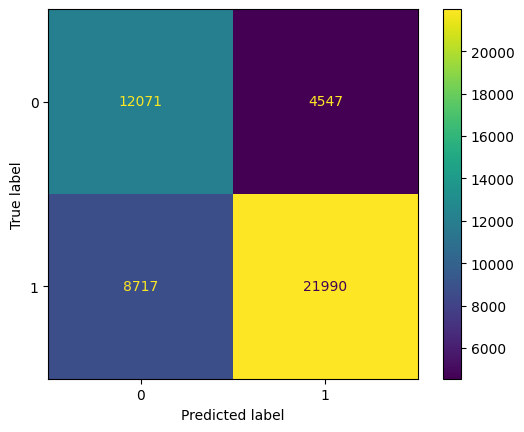

In [22]:
ConfusionMatrixDisplay.from_estimator(logreg, X_test, y_test)

In [23]:
param_grid = {
        'penalty': ['l2'],
        'C': [0.01, 0.1, 1],
        'solver': ['liblinear'],
        'max_iter': [100],
        'class_weight': [None, 'balanced']
    }

In [25]:
grid = GridSearchCV(logreg, param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.01, 0.1, 1],
                         'class_weight': [None, 'balanced'], 'max_iter': [100],
                         'penalty': ['l2'], 'solver': ['liblinear']})

In [26]:
best_logreg = grid.best_estimator_

In [28]:
y_proba = grid.predict_proba(X_test)[:, 1]

In [29]:
threshold = np.arange(0.0, 1.01, 0.01)
results = []

for t in threshold:
    y_pred = (y_proba > t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    results.append((t, fp, fn, tp, tn))

In [30]:
df_thresh = pd.DataFrame(results, columns=['threshold', 'fp', 'fn', 'tp', 'tn'])
df_thresh['Precision'] = df_thresh['tp'] / (df_thresh['tp'] + df_thresh['fp'])
df_thresh['Recall'] = df_thresh['tp'] / (df_thresh['tp'] + df_thresh['fn'])

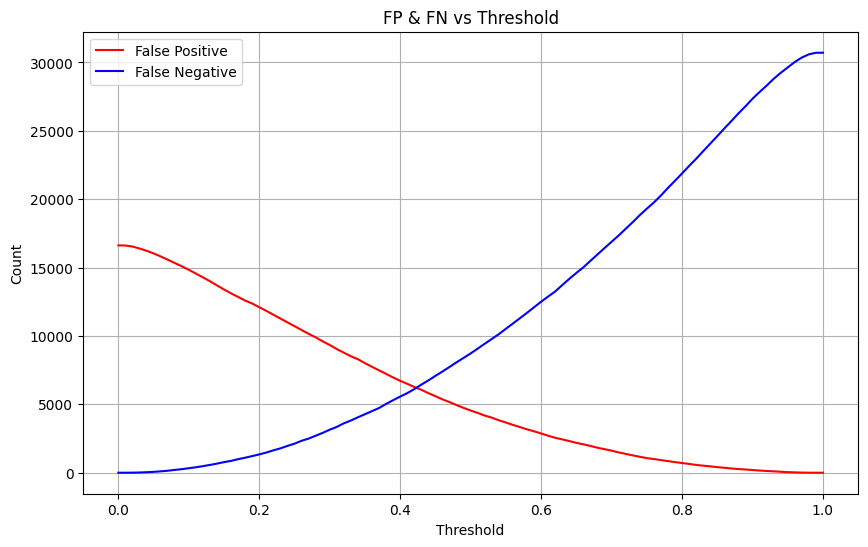

In [31]:
plt.figure(figsize=(10,6))
plt.plot(df_thresh['threshold'], df_thresh['fp'], label='False Positive', color='red')
plt.plot(df_thresh['threshold'], df_thresh['fn'], label='False Negative', color='blue')
plt.xlabel('Threshold')
plt.ylabel('Count')
plt.title('FP & FN vs Threshold')
plt.legend()
plt.grid()
plt.show()

In [36]:
for t in threshold:
    y_pred = (y_proba > t).astype(int)
    print(f"Threshold: {t}")
    print(classification_report(y_test, y_pred))

Threshold: 0.0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     16618
           1       0.65      1.00      0.79     30707

    accuracy                           0.65     47325
   macro avg       0.32      0.50      0.39     47325
weighted avg       0.42      0.65      0.51     47325

Threshold: 0.01
              precision    recall  f1-score   support

           0       1.00      0.00      0.00     16618
           1       0.65      1.00      0.79     30707

    accuracy                           0.65     47325
   macro avg       0.82      0.50      0.39     47325
weighted avg       0.77      0.65      0.51     47325

Threshold: 0.02
              precision    recall  f1-score   support

           0       0.94      0.00      0.01     16618
           1       0.65      1.00      0.79     30707

    accuracy                           0.65     47325
   macro avg       0.80      0.50      0.40     47325
weighted avg       0.75    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.85      0.09      0.17     16618
           1       0.67      0.99      0.80     30707

    accuracy                           0.68     47325
   macro avg       0.76      0.54      0.48     47325
weighted avg       0.73      0.68      0.58     47325

Threshold: 0.1
              precision    recall  f1-score   support

           0       0.84      0.11      0.19     16618
           1       0.67      0.99      0.80     30707

    accuracy                           0.68     47325
   macro avg       0.76      0.55      0.50     47325
weighted avg       0.73      0.68      0.59     47325

Threshold: 0.11
              precision    recall  f1-score   support

           0       0.84      0.12      0.22     16618
           1       0.68      0.99      0.80     30707

    accuracy                           0.68     47325
   macro avg       0.76      0.56      0.51     47325
weighted avg       0.73      0.68      0.60

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [32]:
# Threshold = 0.43
y_pred_best = (y_proba > 0.43).astype(int)

In [33]:
print(classification_report(y_test, y_pred_best))

              precision    recall  f1-score   support

           0       0.62      0.64      0.63     16618
           1       0.80      0.79      0.80     30707

    accuracy                           0.74     47325
   macro avg       0.71      0.71      0.71     47325
weighted avg       0.74      0.74      0.74     47325



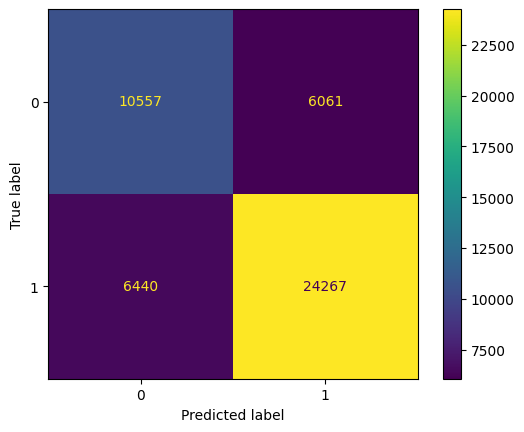

In [34]:
cm_best = confusion_matrix(y_test, y_pred_best)
ConfusionMatrixDisplay(cm_best).plot()

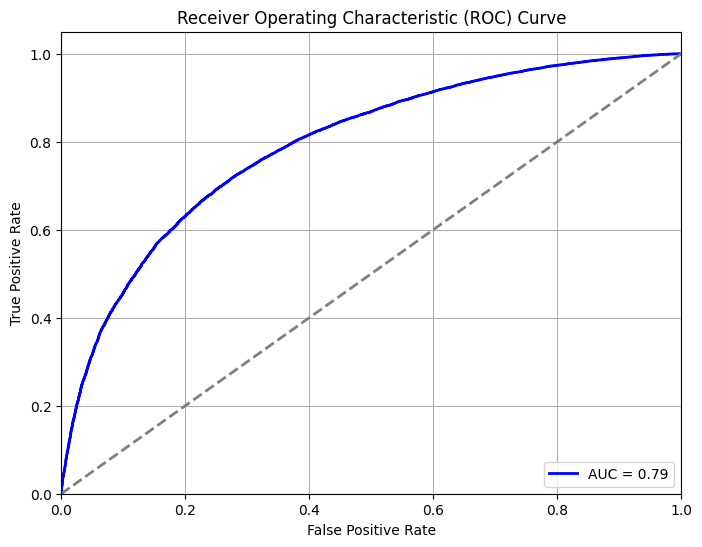

In [37]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # đường random guess
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()